In [11]:
import pandas as pd
import numpy as np
from copy import copy
import importlib
import CF_functions
importlib.reload(CF_functions)
from CF_functions import *
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\wz369\Anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Data

In [46]:
# READING SAVED DATA
org_data = pd.read_pickle('data/data.pkl')

# REFORMAT DATA - WIDE DESIGN MATRIX
# mle_data = copy(data[['Binary','Group','Revenue year','Size','Price']])
mle_data = copy(org_data[['Binary','Group','Revenue year','Size','Price','Nview','Age','Cost','New']])
# LOGALIZE NVIEW,AGE
mle_data['Nview'] = np.log(mle_data['Nview']+1)
mle_data['Age'] = np.log(mle_data['Age'])
mle_data = mle_data.dropna()
# WIDEN
groups = pd.get_dummies(mle_data['Group'])
mle_data['Medium'] = groups.iloc[:,1] 
mle_data['Large'] = groups.iloc[:,2]
times = pd.get_dummies(mle_data['Revenue year'])
mle_data['Year'] = times.iloc[:,1]

D:\Users\lenovo\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [47]:
org_data.head()

,Deal ID,Special Codes,Primary Location,Total Count of Products,Revenue year,Travel Expenses,Closed Won Reason,Annual contract value,Workshop Location,Last Modified Date,...,Nview,Founded,Binary,Customer Size,Price,Size,Age,Group,Cost,New
0,6746637364,NaN,Other,0,2021.0,NaN,NaN,NaN,NaN,2021-11-24 15:49,...,37.0,2010.0,<NA>,528.0,2200,600.0,11.0,2.0,9340.0,0
1,5348381233,NaN,San Francisco,5,2021.0,NaN,NaN,1100000.0,NaN,2021-09-06 15:09,...,15.0,1958.0,0,440.0,2200,500.0,63.0,2.0,9340.0,1
2,6120720003,NaN,Other,0,2021.0,NaN,NaN,NaN,NaN,2021-11-12 10:51,...,71.0,2003.0,<NA>,249.0,2200,282.0,18.0,2.0,9340.0,0
3,5389750890,NaN,Other,2,2021.0,NaN,NaN,565400.0,NaN,2021-09-08 06:49,...,0.0,1932.0,0,227.0,2200,257.0,89.0,2.0,4670.0,1
4,6993070718,NaN,San Francisco,6,2021.0,NaN,NaN,696000.0,NaN,2021-11-23 13:52,...,305.0,2008.0,<NA>,221.0,2200,250.0,13.0,2.0,9340.0,0


# Model Fit

In [3]:
fixed = 0.65
betas = [2.22674415e+03, -5.49937040e+02, -6.66158998e+02, 1.80445730e+02, -4.32924199e+01, 8.05901134e+01, 2.57653653e-03]
data_fitted, tck_nview, s = Value_generation(betas)

np.random.seed(1)
SNC_est = splev(np.log(data_fitted.Nview.astype('float64') + 1), tck_nview)
SNC_var = np.sum(SNC_est) * (1 - fixed) / np.sum(data_fitted.Size)

data_fitted['v_it'] = np.random.logistic(loc=data_fitted.Value, scale=s)

group = [0, 10, 20, 50, 100]
groups = np.zeros(len(data_fitted.Size))
for i, lb in enumerate(group):
    # Assign group based on Qbar_it and the group thresholds;
    # Greater size, larger group number
    groups[data_fitted.Size >= lb] = int(i)
data_fitted['Group'] = groups

newrate = np.mean(data_fitted.New)
cost = [SNC_est, newrate, fixed, SNC_var]
cmat = Consumer_matrix(data_fitted.v_it, data_fitted.Size)

-549.93704 -666.158998


In [12]:
currentQ = [0,9,10,19,20,49,50,99,100,500]
currentP = [2900, 2900, 2700, 2700, 2500, 2500, 2400, 2400, 2300, 2300]
currentY = currentP * np.array(currentQ)
df = Profit(Y=currentY, Q=currentQ, cmat=cmat, cost=cost, continuity=False, group=group)[-1]
df.head()

,Group,Revenue,Cost,Quantity,Value,Acceptance
0,4.0,0.0,0.0,0,Fitted,0
1,4.0,0.0,0.0,0,Fitted,0
2,4.0,0.0,0.0,0,Fitted,0
3,4.0,0.0,0.0,0,Fitted,0
4,4.0,0.0,0.0,0,Fitted,0


In [13]:
df_org = copy(data_fitted[['Group', 'Binary', 'Cost', 'Amount', 'Size']])
# opt_data1['Revenue'] = opt_data1.Price * opt_data1.Size / 1e7
df_org['Value'] = 'Original'
df_org.rename(columns={'Amount': 'Revenue', 'Size': 'Quantity', 'Binary': 'Acceptance'}, inplace=True)
df_org.Revenue = df_org.Revenue / 1e7
df_org.Cost = df_org.Cost * df_org.Quantity * df_org.Acceptance

compare_df = pd.concat([df, df_org]).groupby(['Group', 'Value']).mean().reset_index()
compare_df

,Group,Value,Revenue,Cost,Quantity,Acceptance
0,0.0,Fitted,0.000454,2536.703559,1.567124,0.468658
1,0.0,Original,0.001010,5084.105999,3.316922,0.493678
2,1.0,Fitted,0.002005,7128.023707,7.424074,0.603704
3,1.0,Original,0.003426,27739.8,12.324074,0.487037
4,2.0,Fitted,0.002892,9599.897377,11.567639,0.442971
5,2.0,Original,0.006599,64314.69496,26.310345,0.416446
6,3.0,Fitted,0.007570,24076.944702,31.540541,0.513514
7,3.0,Original,0.014946,252331.459459,62.202703,0.459459
8,4.0,Fitted,0.009042,29020.782727,39.312500,0.3125
9,4.0,Original,0.035575,431683.125,155.625000,0.34375


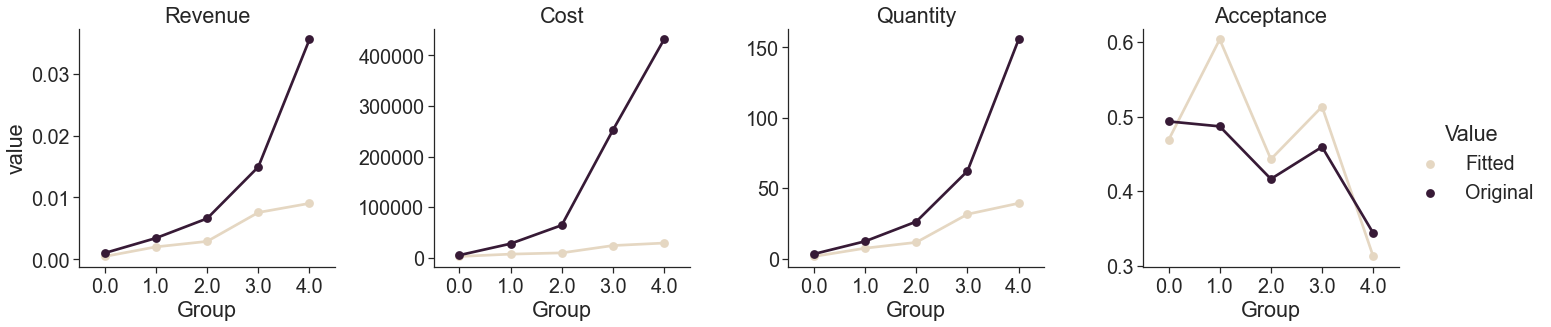

In [52]:
sns.set(font_scale=1.8)
sns.set_style("ticks")
(sns.catplot(data=compare_df.melt(id_vars=['Group', 'Value']),
            x="Group", y="value", hue="Value",
            col="variable", kind="point",
            palette="ch:.25",
            sharey=False)
   .set_titles(col_template="{col_name}")
   .savefig("fig/model_fit.svg", facecolor="w", dpi=400));

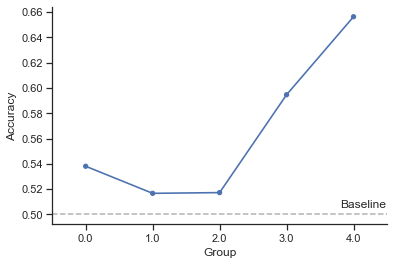

In [47]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

acc = pd.concat([df_org, df.rename(columns={"Acceptance": "Acceptance_f", "Group": "Group1"})], axis=1)
acc['Accuracy'] = np.where(acc.Acceptance == acc.Acceptance_f, 1, 0)
# sns.pointplot(acc.groupby('Group').agg({'Accuracy': 'mean'}).reset_index())
p = sns.pointplot(data=acc.groupby('Group').agg({'Accuracy': 'mean'}).reset_index(),
                  x='Group', y='Accuracy', scale=0.6)
p.axhline(0.5, color='gray', linestyle='--', alpha=0.6)
plt.text(3.8, 0.505, 'Baseline')
p.figure.savefig("fig/model_fit_acc.svg", facecolor="w", dpi=400)